In [1]:
import dynamic_sound as ds
import numpy as np
import os
from scipy.signal import firwin2, freqz
import matplotlib.pyplot as plt

<Figure size 1500x1000 with 0 Axes>

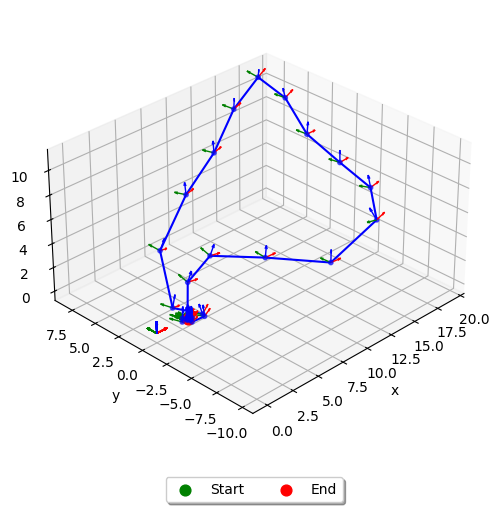

<Figure size 1500x1000 with 0 Axes>

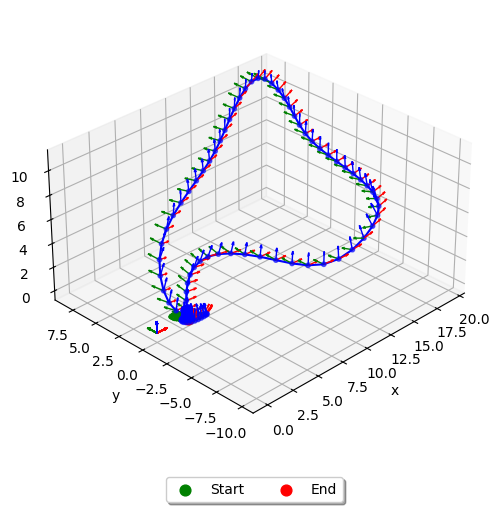

In [15]:
src_folder = r"res/path"
drone_path = ds.Path(file=os.path.join(src_folder, "drone_path.csv"))
microphone_path = ds.Path(file=os.path.join(src_folder, "camera_path.csv"))
drone_sound = r"res/sounds/flying_drone.wav"


# path interpolation
fig = plt.figure(figsize=(15, 10))
ax = drone_path.plot_path_3d(show=False)
drone_path.plot_quaternion_directions(scale=1.0, show=False, ax=ax, legend=False)
microphone_path.plot_quaternion_directions(scale=1.0, show=False, ax=ax, legend=False)
ax.set_aspect('equal')
ax.view_init(elev=30, azim=225)
plt.tight_layout()
plt.savefig("_tmp/path_before_interpolation.png", dpi=300)
plt.show()

drone_path.interpolate_path(120)

fig = plt.figure(figsize=(15, 10))
ax = drone_path.plot_path_3d(show=False)
drone_path.plot_quaternion_directions(scale=1.0, show=False, ax=ax, legend=False)
microphone_path.plot_quaternion_directions(scale=1.0, show=False, ax=ax, legend=False)
ax.set_aspect('equal')
ax.view_init(elev=30, azim=225)
plt.tight_layout()
plt.savefig("_tmp/path_after_interpolation.png", dpi=300)
plt.show()

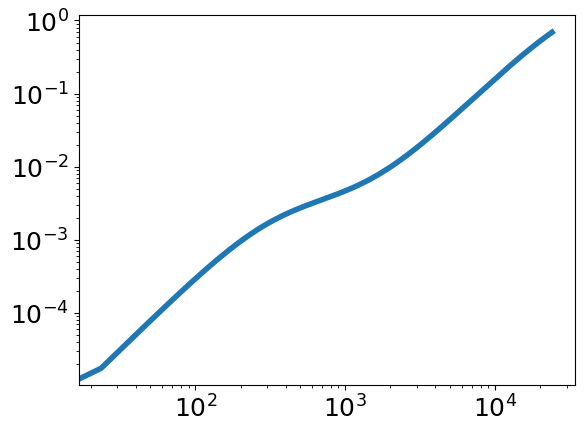

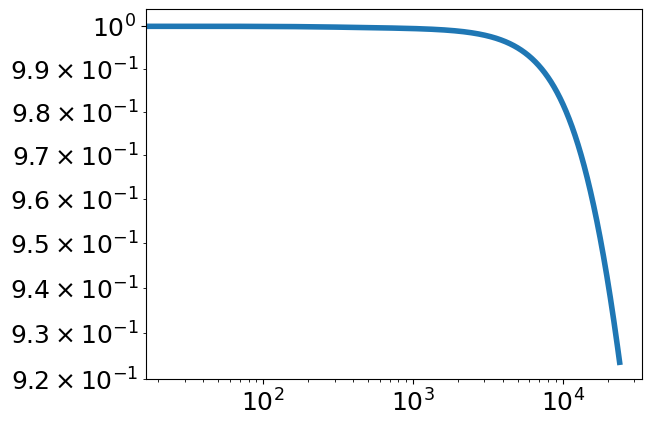

(0.0: 0.00e+00) (23.5: 1.75e-05) (46.9: 6.89e-05) (70.4: 1.52e-04) (93.8: 2.61e-04) (117.3: 3.93e-04) (140.8: 5.41e-04) (164.2: 7.00e-04) (187.7: 8.66e-04) (211.1: 1.03e-03) (234.6: 1.20e-03) (258.1: 1.37e-03) (281.5: 1.53e-03) (305.0: 1.68e-03) (328.4: 1.83e-03) (351.9: 1.97e-03) (375.4: 2.10e-03) (398.8: 2.23e-03) (422.3: 2.36e-03) (445.7: 2.47e-03) (469.2: 2.59e-03) (492.7: 2.70e-03) (516.1: 2.80e-03) (539.6: 2.90e-03) (563.0: 3.00e-03) (586.5: 3.10e-03) (610.0: 3.19e-03) (633.4: 3.28e-03) (656.9: 3.37e-03) (680.4: 3.46e-03) (703.8: 3.55e-03) (727.3: 3.64e-03) (750.7: 3.72e-03) (774.2: 3.81e-03) (797.7: 3.90e-03) (821.1: 3.99e-03) (844.6: 4.07e-03) (868.0: 4.16e-03) (891.5: 4.25e-03) (915.0: 4.34e-03) (938.4: 4.43e-03) (961.9: 4.52e-03) (985.3: 4.61e-03) (1008.8: 4.70e-03) (1032.3: 4.79e-03) (1055.7: 4.89e-03) (1079.2: 4.98e-03) (1102.6: 5.08e-03) (1126.1: 5.18e-03) (1149.6: 5.27e-03) (1173.0: 5.37e-03) (1196.5: 5.48e-03) (1219.9: 5.58e-03) (1243.4: 5.68e-03) (1266.9: 5.79e-03) (129

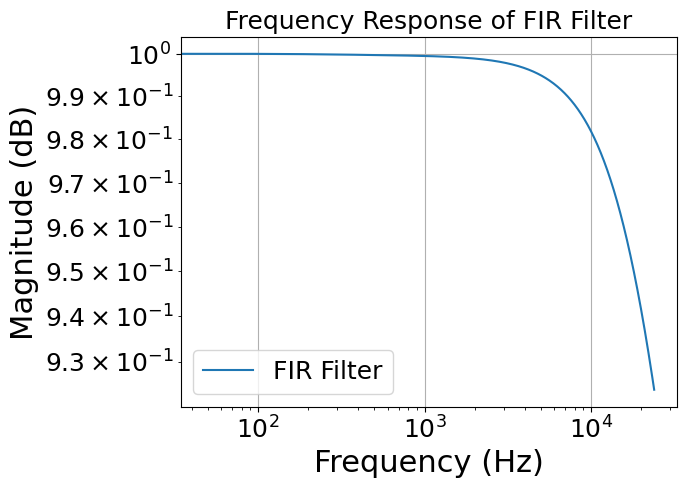

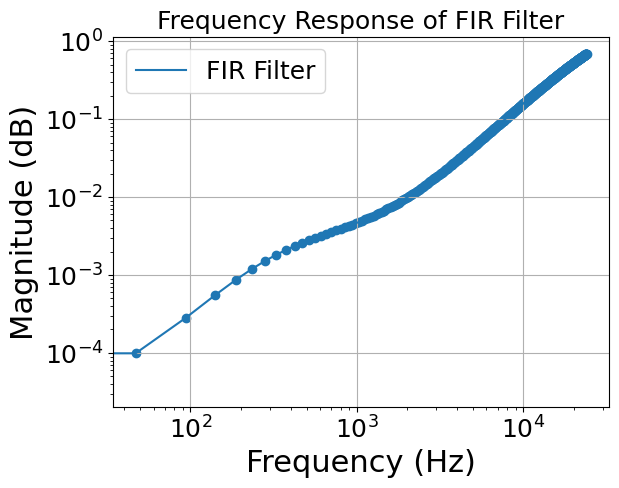

In [20]:
temperature = 20+273.15
relative_humidity = 50 
pressure = 101.325
distance = 1000.0

filter_len = 1025
sample_rate = 48_000

#frequencies = np.logspace(0, sample_rate/2, num=24, endpoint=True, base=10.0)
#frequencies = np.array([50, 63, 80, 100, 125, 160, 200, 250, 315, 400, 500, 630, 800, 1000, 1250, 1600, 2000, 2500, 3150, 4000, 5000, 6300, 8000, 10000])
frequencies = np.logspace(1, 6, 500)
air_absorption_coefficients = ds.acoustics.standards.ISO_9613_1_1993.attenuation_coefficients(
    frequency=frequencies,
    temperature=temperature,
    relative_humidity=relative_humidity,
    pressure=pressure
)
#plt.loglog(frequencies, air_absorption_coefficients*distance)


frequencies = np.linspace(0, sample_rate/2, num=1024)
air_absorption_coefficients = ds.acoustics.standards.ISO_9613_1_1993.attenuation_coefficients(
    frequency=frequencies,
    temperature=temperature,
    relative_humidity=relative_humidity,
    pressure=pressure
)
attenuation_geom = 1.0
air_distance = air_absorption_coefficients
air_coeff = 10 ** (-air_distance / 20.0)
#air_fir_coefficients = firwin2(filter_len, frequencies, air_coeff, fs=sample_rate)

plt.loglog(frequencies, air_distance, linewidth=4)
# plt.ylim(0, 1e3)
plt.show()

plt.loglog(frequencies, air_coeff, linewidth=4)
# plt.ylim(1e-3, 1)
plt.show()

for coeff, freq in [(air_distance[i], frequencies[i]) for i in range(len(air_distance))]:
    print(f"({freq:.1f}: {coeff:.2e})", end=' ')

# build freq/gain arrays for firwin2 (must start at 0 and end at fs/2)
gain_points = (10 ** (-air_distance / 20.0))# * attenuation_geom  # convert dB -> linear amplitude

# compute FIR coefficients
coefficients = firwin2(filter_len, frequencies, gain_points, fs=sample_rate)

print(f"Computed {len(coefficients)} taps:")
print(coefficients)

# Frequency response
w, h = freqz(coefficients, worN=512, fs=sample_rate)

# Plot the frequency response
#plt.figure(figsize=(10, 6))
plt.loglog(w, np.abs(h), label='FIR Filter')
plt.title('Frequency Response of FIR Filter')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid()
# plt.ylim(1e-3, 1)
plt.legend()
plt.show()

plt.loglog(w, -20 * np.log10(np.abs(h)), label='FIR Filter')
plt.scatter(w, -20 * np.log10(np.abs(h)))
plt.title('Frequency Response of FIR Filter')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid()
# plt.xlim(2*10.e3, 30_000)
#plt.ylim(1e-3, 1)
plt.legend()
plt.show()

In [3]:
from dynamic_sound.acoustics.standards.ISO_9613_1_1993 import saturation_pressure, molar_concentration_water_vapour, relaxation_frequency_oxygen, relaxation_frequency_nitrogen, attenuation_coefficients
from dynamic_sound.acoustics.standards.ISO_9613_1_1993 import REFERENCE_PRESSURE, REFERENCE_TEMPERATURE, TRIPLE_TEMPERATURE

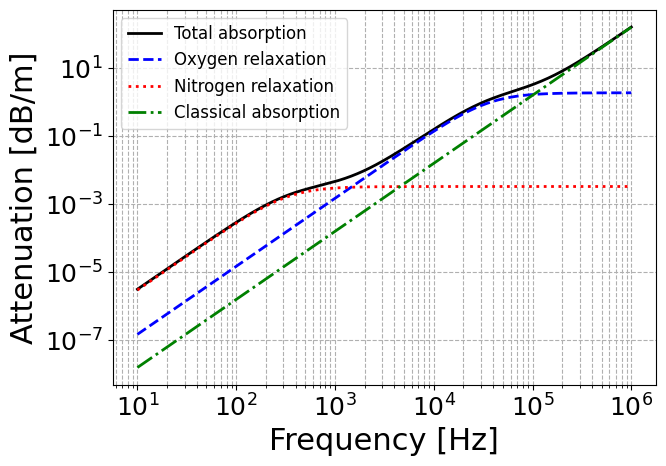

In [10]:
SMALL_SIZE = 18
MEDIUM_SIZE = 22
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


f = np.logspace(1, 6, 500)

temperature = 20+273.15
relative_humidity = 50
pressure = 101.325
Psat = saturation_pressure(temperature=temperature)
h = molar_concentration_water_vapour(relative_humidity=relative_humidity, saturation_pressure=Psat, pressure=pressure)
frO = relaxation_frequency_oxygen(pressure=pressure, h=h)
frN = relaxation_frequency_nitrogen(pressure, temperature, h)
alpha_coeff = attenuation_coefficients(frequency=f, temperature=temperature, pressure=pressure, relative_humidity=relative_humidity)
alpha_C = 8.686 * f**2 * (1.84e-11 * (pressure / REFERENCE_PRESSURE)**(-1) * (temperature / REFERENCE_TEMPERATURE)**0.5)
alpha_O = 8.686 * f**2 * (temperature / REFERENCE_TEMPERATURE)**(-5.0/2.0) * (0.01275 * np.exp(-2239.1 / temperature) / (frO + (f**2 / frO)))
alpha_N = 8.686 * f**2 * (temperature / REFERENCE_TEMPERATURE)**(-5.0/2.0) * (0.1068 * np.exp(-3352.0 / temperature) / (frN + (f**2 / frN)))

plt.figure(figsize=(7, 5))
plt.loglog(f, alpha_coeff, 'k', label="Total absorption", linewidth=2)
plt.loglog(f, alpha_O, 'b', linestyle='--', linewidth=2, label="Oxygen relaxation")
plt.loglog(f, alpha_N, color='r', linestyle=':', linewidth=2, label="Nitrogen relaxation")
plt.loglog(f, alpha_C, color='g', linestyle='-.', linewidth=2, label="Classical absorption")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Attenuation [dB/m]")
#plt.title("ISO 9613-1 Molecular Absorption in Air")
plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.savefig("_tmp/iso_9613_1_attenuation_components.png", dpi=300)
plt.show()

In [47]:
temp = [-20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
freq = np.array([50, 63, 80, 100, 125, 160, 200, 250, 315, 400, 500, 630, 800, 1000, 1250, 1600, 2000, 2500, 3150, 4000, 5000, 6300, 8000, 10000])
humidity = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
pressure = 101.325

distance = 1000
alpha_coeff = 10**(-alpha_coeff * distance / 20)

for temp_i in temp:
    print("----------------------------------")
    print(f"Temperature: {temp_i} °C")
    temp_i = temp_i+273.15
    print("Humidity (%) |", end="")

    for hum_i in humidity:
        print(f"{hum_i:10.0f} |", end="")
         
    for freq_i in freq:
        print(f"\n{freq_i:12.0f} |", end="")
        for hum_i in humidity:
            val = attenuation_coefficients(frequency=freq_i, temperature=temp_i, pressure=pressure, relative_humidity=hum_i)
            print(f"{val*1000:10.2e} |", end="")
    
    print()

----------------------------------
Temperature: -20 °C
Humidity (%) |        10 |        20 |        30 |        40 |        50 |        60 |        70 |        80 |        90 |       100 |
          50 |  5.87e-01 |  4.17e-01 |  2.84e-01 |  2.10e-01 |  1.67e-01 |  1.42e-01 |  1.25e-01 |  1.13e-01 |  1.05e-01 |  9.89e-02 |
          63 |  7.55e-01 |  6.01e-01 |  4.20e-01 |  3.07e-01 |  2.41e-01 |  1.99e-01 |  1.73e-01 |  1.55e-01 |  1.42e-01 |  1.33e-01 |
          80 |  9.29e-01 |  8.55e-01 |  6.27e-01 |  4.61e-01 |  3.56e-01 |  2.90e-01 |  2.46e-01 |  2.16e-01 |  1.96e-01 |  1.80e-01 |
         100 |  1.08e+00 |  1.15e+00 |  9.02e-01 |  6.75e-01 |  5.21e-01 |  4.19e-01 |  3.50e-01 |  3.03e-01 |  2.69e-01 |  2.45e-01 |
         125 |  1.20e+00 |  1.48e+00 |  1.27e+00 |  9.86e-01 |  7.67e-01 |  6.14e-01 |  5.08e-01 |  4.33e-01 |  3.80e-01 |  3.40e-01 |
         160 |  1.31e+00 |  1.85e+00 |  1.79e+00 |  1.48e+00 |  1.17e+00 |  9.46e-01 |  7.79e-01 |  6.59e-01 |  5.70e-01 |  5.03e-01 |
